# Optimizers for Training Neural Networks

In [1]:
%load_ext autoreload
%autoreload 2

import banner

topics = ['SGD',
          'AdamW',
          'SCG',
          'Demonstrations on Training Weights for Neural Network with Single Hidden Layer']

banner.reset(topics)



Topics in this Notebook

1. SGD
2. AdamW
3. SCG
4. Demonstrations on Training Weights for Neural Network with Single Hidden Layer


$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\Yv}{\mathbf{Y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\gv}{\mathbf{g}}
\newcommand{\Hv}{\mathbf{H}}
\newcommand{\dv}{\mathbf{d}}
\newcommand{\Vv}{\mathbf{V}}
\newcommand{\vv}{\mathbf{v}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\Zv}{\mathbf{Z}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}
\newcommand{\dimensionbar}[1]{\underset{#1}{\operatorname{|}}}
$

In [2]:
%%writefile optimizers.py

import numpy as np
import copy
import math
import sys  # for sys.float_info.epsilon

def next_minibatch(X, T, batch_size):
    rows = np.arange(X.shape[0])
    np.random.shuffle(rows)
    n_samples = X.shape[0]
    for first in range(0, n_samples, batch_size):
        last = first + batch_size
        if last > n_samples:
            break
        yield X[first:last, :], T[first:last, :]

######################################################################
## class Optimizers()
######################################################################

class Optimizers():

    def __init__(self, all_weights):
        '''all_weights is a vector of all of a neural networks weights concatenated into a one-dimensional vector'''
        
        self.all_weights = all_weights
        self.error_trace = []
        self.best_val_error = None
        self.best_epoch = None
        self.best_weights = None 

    


Overwriting optimizers.py


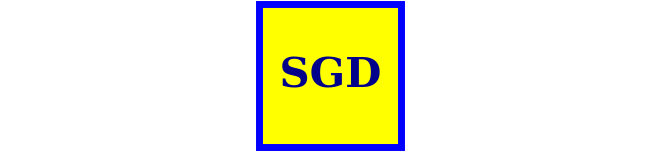

In [3]:
banner.next_topic()

# SGD

In [4]:
%%writefile -a optimizers.py
    def sgd(self, Xtrain, Ttrain, Xval, Tval, error_f, gradient_f, 
            n_epochs=100, batch_size=-1, learning_rate=0.001, momentum=0, weight_penalty=0,
            error_convert_f=None, error_convert_name='MSE', verbose=True):
            '''
            Xtrain : two-dimensional numpy array 
                number of training samples  by  number of input components
            Ttrain : two-dimensional numpy array
                number of training samples  by  number of output components
            Xvalidate : two-dimensional numpy array 
                number of validation samples  by  number of input components
            Tvalidate : two-dimensional numpy array
                number of validationg samples  by  number of output components
            error_f: function that requires X and T as arguments (given in fargs) and returns mean squared error.
            gradient_f: function that requires X and T as arguments (in fargs) and returns gradient of mean squared error
                        with respect to each weight.
            n_epochs : int
                Number of passes to take through all samples
            batch_size: if -1, then batch_size is Xtrain.shape[0], all of training data
            learning_rate : float
                Controls the step size of each update, only for sgd and adam
            momentum : float
                Controls amount of previous weight update to add to current weight update, only for sgd
            weight_penalty : float
                Controls amount to penalize large magnitude weights
            error_convert_f: function that converts the standardized error from error_f to original T units
            error_convert_name: used when printing progress updates
            verbose: if True print progress occasionally
            '''
    
            if self.error_trace == []:
                # not initialized yet
                self.prev_update = 0
    
            if batch_size == -1:
                batch_size = Xtrain.shape[0]
                
            epochs_per_print = n_epochs // 10
    
            # print('first weights\n', self.Ws)
            for epoch in range(n_epochs):
    
                for Xbatch, Tbatch in next_minibatch(Xtrain, Ttrain, batch_size):
    
                    # Assume to be standardized already
                    error = error_f(Xbatch, Tbatch) + weight_penalty * np.sum(self.all_weights ** 2)
                    grad = gradient_f(Xbatch, Tbatch) + weight_penalty * 2 * self.all_weights
                    
                    self.prev_update = learning_rate * grad + momentum * self.prev_update
                    # Update all weights using -= to modify their values in-place.
                    self.all_weights -= self.prev_update
    
                train_error = 0.0
                for Xbatch, Tbatch in next_minibatch(Xtrain, Ttrain, batch_size):
                    train_error += error_f(Xbatch, Tbatch) + weight_penalty * np.sum(self.all_weights ** 2)
                n_batches = int(Xtrain.shape[0] / batch_size)
                train_error /= n_batches
                
                val_error = error_f(Xval, Tval) + weight_penalty * np.sum(self.all_weights ** 2)
                
                if self.best_val_error is None or val_error < self.best_val_error:
                    self.best_val_error = val_error
                    self.best_epoch = epoch
                    self.best_weights = self.all_weights.copy()

                if error_convert_f:
                    train_error = error_convert_f(train_error)
                    val_error = error_convert_f(val_error)
    
                self.error_trace.append([train_error, val_error])
    
                if verbose and ((epoch + 1) % max(1, epochs_per_print) == 0):
                    print(f'SGD: Epoch {epoch + 1} {error_convert_name} = Train {train_error:.5f} Validate {val_error:.5f}')
    
                # print('epoch', epoch, 'weights\n', self.Ws)

            self.all_weights[:] = self.best_weights
    
            return self.error_trace



Appending to optimizers.py


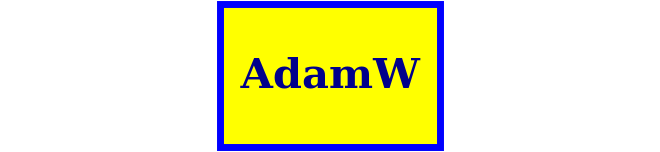

In [5]:
banner.next_topic()

# AdamW

Now we add the basic [Adaptive Moment Estimation (Adam)](https://ruder.io/optimizing-gradient-descent/index.html#adam).  

In [6]:
%%writefile -a optimizers.py
    ######################################################################
    #### adamw
    ######################################################################

    def adamw(self, Xtrain, Ttrain, Xval, Tval, error_f, gradient_f, 
              n_epochs=100, batch_size=-1, learning_rate=0.001, momentum=0 ,weight_penalty=0,
              error_convert_f=None, error_convert_name='MSE', verbose=True):
        '''
        Xtrain : two-dimensional numpy array 
            number of training samples  by  number of input components
        Ttrain : two-dimensional numpy array
            number of training samples  by  number of output components
        Xvalidate : two-dimensional numpy array 
            number of validation samples  by  number of input components
        Tvalidate : two-dimensional numpy array
            number of validationg samples  by  number of output components
        error_f: function that requires X and T as arguments (given in fargs) and returns mean squared error.
        gradient_f: function that requires X and T as arguments (in fargs) and returns gradient of mean squared error
                    with respect to each weight.
        n_epochs : int
            Number of passes to take through all samples
        batch_size: if -1, then batch_size = Xtrain.shape[0], all training samples
        learning_rate : float
            Controls the step size of each update, only for sgd and adam
        momentum : float. Not used in adamw
        weight_penalty : float
            Controls amount to penalize large magnitude weights
        error_convert_f: function that converts the standardized error from error_f to original T units
        error_convert_name: used when printing progress updates
        weight_penalty: if > 0, penalize large magnitude weights
        verbose: if True print progress occasionally
        '''

        if self.error_trace == []:
            shape = self.all_weights.shape
            # with multiple subsets (batches) of training data.
            self.mt = np.zeros(shape)
            self.vt = np.zeros(shape)
            self.sqrt = np.sqrt
                
            self.beta1 = 0.9
            self.beta2 = 0.999
            self.beta1t = 1
            self.beta2t = 1

        if batch_size == -1:
            batch_size = Xtrain.shape[0]

        alpha = learning_rate  # learning rate called alpha in original paper on adam
        epsilon = 1e-8
        epochs_per_print = n_epochs // 10

        for epoch in range(n_epochs):

            for Xbatch, Tbatch in next_minibatch(Xtrain, Ttrain, batch_size):

                error = error_f(Xbatch, Tbatch) + weight_penalty * np.sum(self.all_weights ** 2)
                grad = gradient_f(Xbatch, Tbatch) + weight_penalty * 2 * self.all_weights
    
                self.mt[:] = self.beta1 * self.mt + (1 - self.beta1) * grad
                self.vt[:] = self.beta2 * self.vt + (1 - self.beta2) * grad * grad
                self.beta1t *= self.beta1
                self.beta2t *= self.beta2
    
                m_hat = self.mt / (1 - self.beta1t)
                v_hat = self.vt / (1 - self.beta2t)
    
                # Update all weights using -= to modify their values in-place.
                self.all_weights -= (alpha * m_hat / (self.sqrt(v_hat) + epsilon) + 
                                     weight_penalty * self.all_weights)
                
            train_error = 0.0
            for Xbatch, Tbatch in next_minibatch(Xtrain, Ttrain, batch_size):
                train_error += error_f(Xbatch, Tbatch) + weight_penalty * np.sum(self.all_weights ** 2)
            n_batches = int(Xtrain.shape[0] / batch_size)
            train_error /= n_batches
            val_error = error_f(Xval, Tval) + weight_penalty * np.sum(self.all_weights ** 2)

            if self.best_val_error is None or val_error < self.best_val_error:
                self.best_val_error = val_error
                self.best_epoch = epoch
                self.best_weights = self.all_weights.copy()
                
            if error_convert_f:
                train_error = error_convert_f(train_error)
                val_error = error_convert_f(val_error)

            self.error_trace.append([train_error, val_error])

            if verbose and ((epoch + 1) % max(1, epochs_per_print) == 0):
                print(f'AdamW: Epoch {epoch + 1} {error_convert_name} = Train {train_error:.5f} Validate {val_error:.5f}')

        self.all_weights[:] = self.best_weights

        return self.error_trace



Appending to optimizers.py


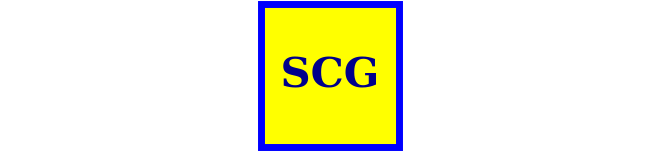

In [7]:
banner.next_topic()

# SCG 

And now the Scaled Conjugate Gradient, scg, algorithm. NOT USING BATCHES YET

In [8]:
%%writefile -a optimizers.py
    ######################################################################
    #### scg
    ######################################################################

    def scg(self, Xtrain, Ttrain, Xval, Tval, error_f, gradient_f, 
            n_epochs=100, batch_size=-1, learning_rate=0.0, momentum=0.0, weight_penalty=0,
            error_convert_f=None, error_convert_name='MSE', verbose=True):
        '''
        Xtrain : two-dimensional numpy array 
            number of training samples  by  number of input components
        Ttrain : two-dimensional numpy array
            number of training samples  by  number of output components
        Xvalidate : two-dimensional numpy array 
            number of validation samples  by  number of input components
        Tvalidate : two-dimensional numpy array
            number of validationg samples  by  number of output components
        error_f: function that requires X and T as arguments (given in fargs) and returns mean squared error.
        gradient_f: function that requires X and T as arguments (in fargs) and returns gradient of mean squared error
                    with respect to each weight.
        n_epochs : int
        batch_size: if -1, batch_size is Xtrain.shape[0], or all training samples
            Number of passes to take through all samples
        learning_rate:  not used for scg
        momentum : float. Not used in scg
        weight_penalty : float
            Controls amount to penalize large magnitude weights
        error_convert_f: function that converts the standardized error from error_f to original T units
        error_convert_name: used when printing progress updates
        weight_penalty: if > 0, penalize large magnitude weights
        verbose: if True print progress occasionally
        '''

        if batch_size == -1:
            batch_size = Xtrain.shape[0]
            
        if self.error_trace == []:
            shape = self.all_weights.shape
            self.w_new = np.zeros(shape)
            self.w_temp = np.zeros(shape)
            self.g_new = np.zeros(shape)
            self.g_old = np.zeros(shape)
            self.g_smallstep = np.zeros(shape)
            self.search_dir = np.zeros(shape)

        sigma0 = 1.0e-6
        
        fold = 0.0
        for Xbatch, Tbatch in next_minibatch(Xtrain, Ttrain, batch_size):
            fold += error_f(Xtrain, Ttrain) + weight_penalty * np.sum(self.all_weights ** 2)
            self.g_new[:] += gradient_f(Xtrain, Ttrain) + weight_penalty * 2 * self.all_weights
        n_batches = int(Xtrain.shape[0] / batch_size)
        fold /= n_batches
        self.g_new /= n_batches

        val_fold = error_f(Xval, Tval) + weight_penalty * np.sum(self.all_weights ** 2)

        error = fold
        val_error = val_fold
        self.g_old[:] = copy.deepcopy(self.g_new)
        self.search_dir[:] = -self.g_new
        success = True				# Force calculation of directional derivs.
        nsuccess = 0				# nsuccess counts number of successes.
        beta = 1.0e-6				# Initial scale parameter. Lambda in Moeller.
        betamin = 1.0e-15 			# Lower bound on scale.
        betamax = 1.0e20			# Upper bound on scale.
        nvars = len(self.all_weights)
        epoch = 1				# j counts number of epochs

        # Main optimization loop.
        for epoch in range(n_epochs):  #while epoch <= n_epochs:

            for Xbatch, Tbatch in next_minibatch(Xtrain, Ttrain, batch_size):
                
                # Calculate first and second directional derivatives.
                if success:
                    mu = self.search_dir @ self.g_new
                    if mu >= 0:
                        self.search_dir[:] = - self.g_new
                        mu = self.search_dir.T @ self.g_new
                    kappa = self.search_dir.T @ self.search_dir
                    if math.isnan(kappa):
                        print('kappa', kappa)
    
                    if kappa < sys.float_info.epsilon:
                        return self.error_trace
    
                    sigma = sigma0 / math.sqrt(kappa)
    
                    self.w_temp[:] = self.all_weights
                    self.all_weights += sigma * self.search_dir
                    self.g_smallstep[:] = 0.
                    for Xbatch, Tbatch in next_minibatch(Xtrain, Ttrain, batch_size):
                        error_f(Xtrain, Ttrain) + weight_penalty * np.sum(self.all_weights ** 2)
                        self.g_smallstep[:] += gradient_f(Xtrain, Ttrain) + weight_penalty * 2 * self.all_weights
                    n_batches = int(Xtrain.shape[0] / batch_size)
                    self.g_smallstep /= n_batches
                    self.all_weights[:] = self.w_temp
    
                    theta = self.search_dir @ (self.g_smallstep - self.g_new) / sigma
                    if math.isnan(theta):
                        print('theta', theta, 'sigma', sigma, 'search_dir[0]', self.search_dir[0], 'g_smallstep[0]', self.g_smallstep[0])
    
                ## Increase effective curvature and evaluate step size alpha.
    
                delta = theta + beta * kappa
                # if math.isnan(scalarv(delta)):
                if math.isnan(delta):
                    print('delta is NaN', 'theta', theta, 'beta', beta, 'kappa', kappa)
                elif delta <= 0:
                    delta = beta * kappa
                    beta = beta - theta / kappa
    
                if delta == 0:
                    success = False
                    fnow = fold
                    val_fnow = val_fold
                else:
                    alpha = -mu / delta
                    ## Calculate the comparison ratio Delta
                    self.w_temp[:] = self.all_weights
                    self.all_weights += alpha * self.search_dir
                    val_fnew = error_f(Xval, Tval) + weight_penalty * np.sum(self.all_weights ** 2)
                    fnew = 0
                    for Xbatch, Tbatch in next_minibatch(Xtrain, Ttrain, batch_size):
                        fnew += error_f(Xtrain, Ttrain) + weight_penalty * np.sum(self.all_weights ** 2)
                    n_batches = int(Xtrain.shape[0] / batch_size)
                    fnew /= n_batches
                    Delta = 2 * (fnew - fold) / (alpha * mu)
                    if not math.isnan(Delta) and Delta  >= 0:
                        success = True
                        nsuccess += 1
                        fnow = fnew
                        val_fnow = val_fnew
                    else:
                        success = False
                        fnow = fold
                        val_fnow = val_fold
                        self.all_weights[:] = self.w_temp
    
                if success:
    
                    fold = fnew
                    val_fold = val_fnew
                    val_error = val_fold  # ?
                    self.g_old[:] = self.g_new
                    # does error_f need to be called here to set self.Zs?
                    self.g_new[:] = gradient_f(Xtrain, Ttrain) + weight_penalty * 2 * self.all_weights
    
                    # If the gradient is zero then we are done.
                    # gg = self.g_new @ self.g_new  # dot(gradnew, gradnew)
                    # if gg == 0:
                        # return self.error_trace
    
                if math.isnan(Delta) or Delta < 0.25:
                    beta = min(4.0 * beta, betamax)
                elif Delta > 0.75:
                    beta = max(0.5 * beta, betamin)
    
                # Update search direction using Polak-Ribiere formula, or re-start
                # in direction of negative gradient after nparams steps.
                if nsuccess == nvars:
                    self.search_dir[:] = -self.g_new
                    nsuccess = 0
                elif success:
                    gamma = (self.g_old - self.g_new) @ (self.g_new / mu)
                    #self.search_dir[:] = gamma * self.search_dir - self.g_new
                    self.search_dir *= gamma
                    self.search_dir -= self.g_new

                    
            # end of batch loop

            error = 0.0
            for Xbatch, Tbatch in next_minibatch(Xtrain, Ttrain, batch_size):
                error += error_f(Xtrain, Ttrain) + weight_penalty * np.sum(self.all_weights ** 2)
            n_batches = int(Xtrain.shape[0] / batch_size)
            error /= n_batches

            val_error = error_f(Xval, Tval) + weight_penalty * np.sum(self.all_weights ** 2)

            if error_convert_f:
                val_error_converted = error_convert_f(val_error)
                error_converted = error_convert_f(error)
            else:
                error_converted = error
                val_error_converted = val_error
            self.error_trace.append([error_converted, val_error_converted])
    
            epochs_per_print = math.ceil(n_epochs/10)
            if verbose and ((epoch + 1) % max(1, epochs_per_print) == 0):
                print(f'SCG: Epoch {epoch + 1} {error_convert_name}= Train {error_converted:.5f} Validate {val_error_converted:.5f}')

            if self.best_val_error is None or val_error < self.best_val_error:
                self.best_val_error = val_error
                self.best_epoch = epoch
                self.best_weights = self.all_weights.copy()

            # end of epoch loop
            
        self.all_weights[:] = self.best_weights

        return self.error_trace



Appending to optimizers.py


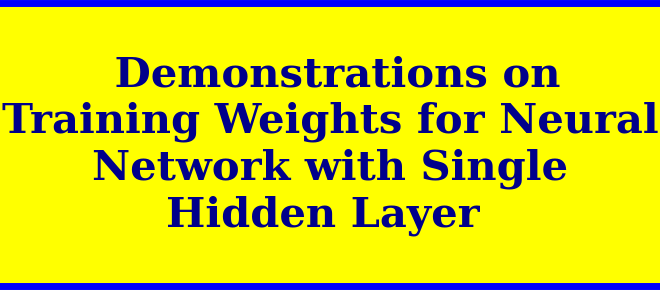

In [9]:
banner.next_topic()

# Demonstration of Training Weights for Neural Network with Single Hidden Layer

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import optimizers as opt

In [11]:
######################################################################
# Make date and partition randomly into training, validation, and testing

Xtrain = np.arange(-2, 2, 0.03).reshape(-1, 1)
Ttrain = np.sin(Xtrain * 2) * np.sin(Xtrain * 5)
    
Xval = Xtrain * 1.1  # + 0.2
Tval = Ttrain + 0.2 * Xtrain
Xtest = Xtrain * 0.97
Ttest = Ttrain + 0.15 * Xtrain # + np.random.uniform(-0.05, 0.05, Ttrain.shape) 
        
n_samples, n_inputs = Xtrain.shape
n_outputs = Ttrain.shape[1]

In [12]:
######################################################################
# Make weight and gradient one-dimensional vectors and matrix views
# Neural net has only one hidden layer.

def make_weight_and_gradient_matrices(n_inputs, n_hiddens, n_outputs):
    
    # Weight vector and matrix views
        
    Vshape = (1 + n_inputs, n_hiddens)
    Wshape = (1 + n_hiddens, n_outputs)
    
    n_V = np.prod(Vshape)
    n_W = np.prod(Wshape)
    n_weights = n_V + n_W
    all_weights = np.random.uniform(-1, 1, n_weights)
    V = all_weights[:n_V].reshape(Vshape)
    V /= np.sqrt(Vshape[0])
    W = all_weights[n_V:].reshape(Wshape)
    W /= np.sqrt(Wshape[0])
    W[:] = 0.0  # set output layer weights to zeros
    
    # Gradient vector and matrix views
    
    all_gradients = np.zeros_like(all_weights)
    grad_V = all_gradients[:n_V].reshape(Vshape)
    grad_W = all_gradients[n_V:].reshape(Wshape) 

    return all_weights, V, W, all_gradients, grad_V, grad_W

all_weights, V, W, all_gradients, grad_V, grad_W = make_weight_and_gradient_matrices(n_inputs, 10, n_outputs)

In [13]:
all_gradients

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [14]:
grad_W

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [15]:
######################################################################
# Neural network functions
    
def rmse_unstandardized(T, Y, Tstds):
    return np.sqrt(np.mean((T - Y)**2, axis=0))[0]

def add_ones(A):
    return np.insert(A, 0, 1, axis=1)

# Function to be minimized by optimizer method, mean squared error
def error_f(X, T):
    global Z, Y
    # forward pass
    Z = np.tanh(add_ones(X) @ V)
    Y = add_ones(Z) @ W
    mean_sq_error = np.mean((T - Y) ** 2)
    return mean_sq_error

# Gradient of function to be minimized for use by optimizer method
def gradient_f(X, T):
    global Z, Y, grad_W, grad_V, all_gradients   # remove ones that aren't changed in this function
    n_samples = X.shape[0]
    n_outputs = T.shape[1]
    Dw = -2 * (T - Y) / (n_samples * n_outputs)
    Dv = Dw @ W[1:, :].T * (1 - Z**2)
    grad_W[:] = add_ones(Z).T @ Dw
    grad_V[:] = add_ones(X).T @ Dv
    return all_gradients

# Apply network to data X
def use(X):
    X = (X - Xmeans) / Xstds
    Z = np.tanh(add_ones(X) @ V)
    Y = add_ones(Z) @ W
    return Y * Tstds + Tmeans

In [16]:
######################################################################
# Standardize data
    
Xmeans = Xtrain.mean(axis=0)
Xstds = Xtrain.std(axis=0)
Tmeans = Ttrain.mean(axis=0)
Tstds = Ttrain.std(axis=0)

XtrainS = (Xtrain - Xmeans) / Xstds
TtrainS = (Ttrain - Tmeans) / Tstds
XvalS = (Xval - Xmeans) / Xstds
TvalS = (Tval - Tmeans) / Tstds
# XtestS = (Xtest - Xmeans) / Xstds
# TtestS = (Ttest - Tmeans) / Tstds

In [17]:
def plot_results(error_trace, optimizer, method):
    plt.figure(figsize=(8, 10))
    plt.subplot(3, 1, 1)
    plt.plot(error_trace)
    plt.axvline(optimizer.best_epoch, ymin=0, ymax=1, color='black', lw=4, alpha=0.2)
    
    plt.subplot(3, 1, 2)
    plt.plot(Xtrain, Ttrain, 'b.', label='Ttrain')
    plt.plot(Xtrain, use(Xtrain), 'b-', label='Ytrain')
    
    plt.plot(Xval, Tval, 'r.', label='Tval')
    plt.plot(Xtest, Ttest, 'c.', label='Ttest')
    plt.legend()
    
    title = f'{method}: RMSE Train {rmse_unstandardized(Ttrain, use(Xtrain), Tstds):.2f}'
    title += f' Val {rmse_unstandardized(Tval, use(Xval), Tstds):.2f}'
    title += f' Test {rmse_unstandardized(Ttest, use(Xtest), Tstds):.2f}'
    title += f' Best Epoch {optimizer.best_epoch:,}'  # what is this comma doing ?    
    plt.title(title)

    Zs = np.tanh(add_ones(Xtrain) @ V)
    plt.subplot(3, 1, 3)
    plt.plot(Zs)
    plt.ylabel('Hidden Unit Outputs')

    plt.tight_layout();

n_hiddens=20
SGD: Epoch 10000 MSE = Train 0.18912 Validate 0.51130
SGD: Epoch 20000 MSE = Train 0.11566 Validate 0.48489
SGD: Epoch 30000 MSE = Train 0.09605 Validate 0.47749
SGD: Epoch 40000 MSE = Train 0.07878 Validate 0.47783
SGD: Epoch 50000 MSE = Train 0.06930 Validate 0.47794
SGD: Epoch 60000 MSE = Train 0.06412 Validate 0.47677
SGD: Epoch 70000 MSE = Train 0.06076 Validate 0.47629
SGD: Epoch 80000 MSE = Train 0.05830 Validate 0.47584
SGD: Epoch 90000 MSE = Train 0.05637 Validate 0.47520
SGD: Epoch 100000 MSE = Train 0.05474 Validate 0.47418


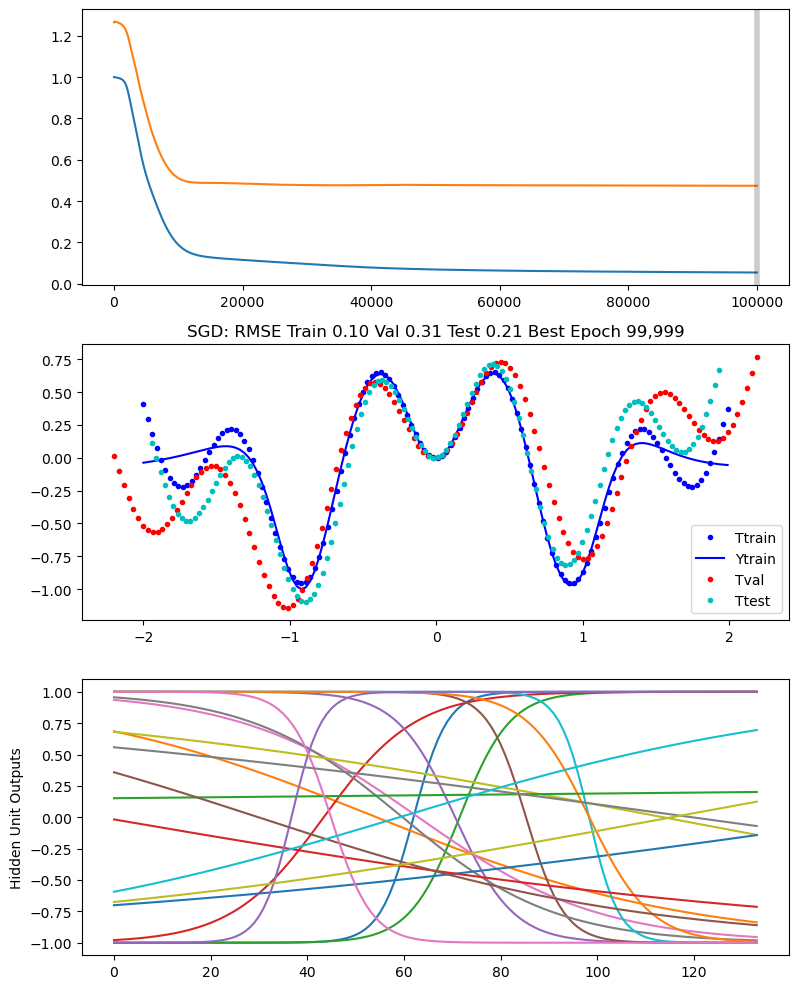

In [18]:
n_hiddens = 20
print(f'{n_hiddens=}')

all_weights, V, W, all_gradients, grad_V, grad_W = make_weight_and_gradient_matrices(n_inputs, n_hiddens, n_outputs)
optimizer = opt.Optimizers(all_weights)

n_epochs = 100_000
learning_rate = 0.02
momentum = 0.
weight_penalty = 0.0
error_trace = optimizer.sgd(XtrainS, TtrainS, XvalS, TvalS, error_f, gradient_f,
                            n_epochs=n_epochs, batch_size=-1, learning_rate=learning_rate,
                            momentum=momentum, weight_penalty=weight_penalty,
                            verbose=True)

plot_results(error_trace, optimizer, 'SGD')

That was without mini-batches.  Now try `batch_size` of 10 and 1/10th the number of epochs.

n_hiddens=20
SGD: Epoch 1000 MSE = Train 0.51991 Validate 0.89556
SGD: Epoch 2000 MSE = Train 0.18054 Validate 0.51244
SGD: Epoch 3000 MSE = Train 0.11599 Validate 0.49932
SGD: Epoch 4000 MSE = Train 0.09685 Validate 0.50556
SGD: Epoch 5000 MSE = Train 0.07551 Validate 0.53404
SGD: Epoch 6000 MSE = Train 0.05692 Validate 0.58636
SGD: Epoch 7000 MSE = Train 0.04525 Validate 0.64362
SGD: Epoch 8000 MSE = Train 0.03916 Validate 0.69145
SGD: Epoch 9000 MSE = Train 0.03566 Validate 0.72480
SGD: Epoch 10000 MSE = Train 0.03306 Validate 0.74628


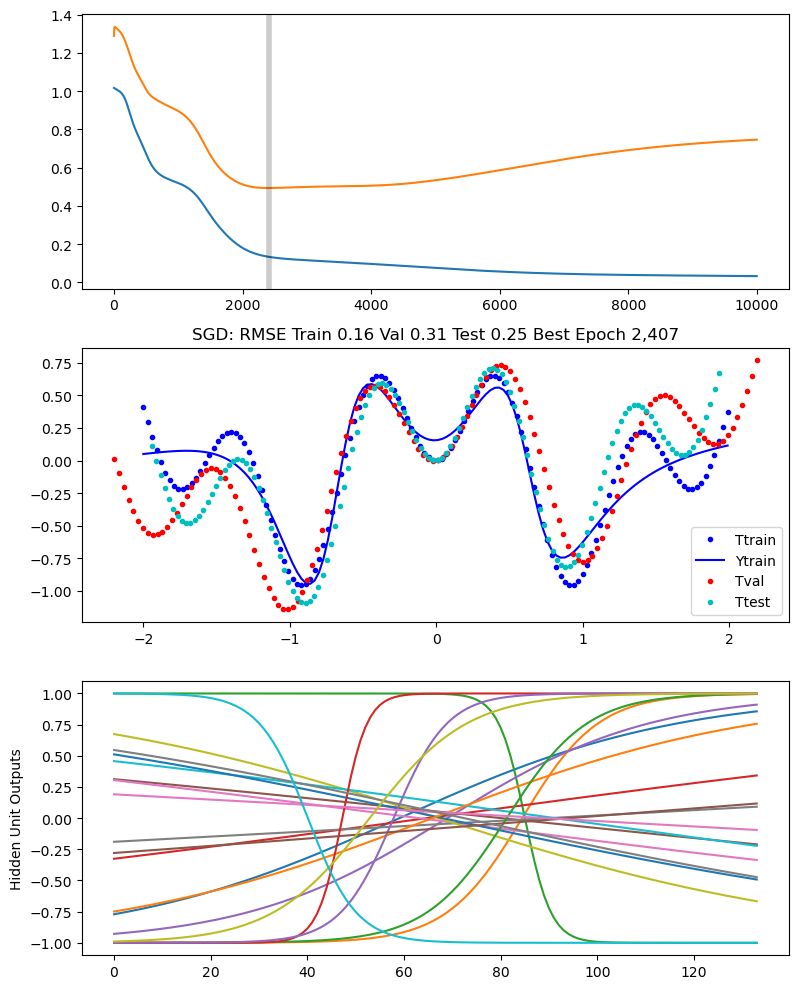

In [19]:
# n_hiddens = 20
print(f'{n_hiddens=}')

all_weights, V, W, all_gradients, grad_V, grad_W = make_weight_and_gradient_matrices(n_inputs, n_hiddens, n_outputs)
optimizer = opt.Optimizers(all_weights)

n_epochs = 10_000
learning_rate = 0.01
momentum = 0.
weight_penalty = 0.0
error_trace = optimizer.sgd(XtrainS, TtrainS, XvalS, TvalS, error_f, gradient_f,
                            n_epochs=n_epochs, batch_size=10, learning_rate=learning_rate,
                            momentum=momentum, weight_penalty=weight_penalty,
                            verbose=True)

plot_results(error_trace, optimizer, 'SGD')

n_hiddens=20
AdamW: Epoch 500 MSE = Train 0.05627 Validate 0.46810
AdamW: Epoch 1000 MSE = Train 0.02314 Validate 0.43372
AdamW: Epoch 1500 MSE = Train 0.00122 Validate 0.62757
AdamW: Epoch 2000 MSE = Train 0.00031 Validate 0.67869
AdamW: Epoch 2500 MSE = Train 0.00013 Validate 0.69560
AdamW: Epoch 3000 MSE = Train 0.00007 Validate 0.70820
AdamW: Epoch 3500 MSE = Train 0.00004 Validate 0.71394
AdamW: Epoch 4000 MSE = Train 0.00003 Validate 0.71624
AdamW: Epoch 4500 MSE = Train 0.00002 Validate 0.71971
AdamW: Epoch 5000 MSE = Train 0.00002 Validate 0.72092


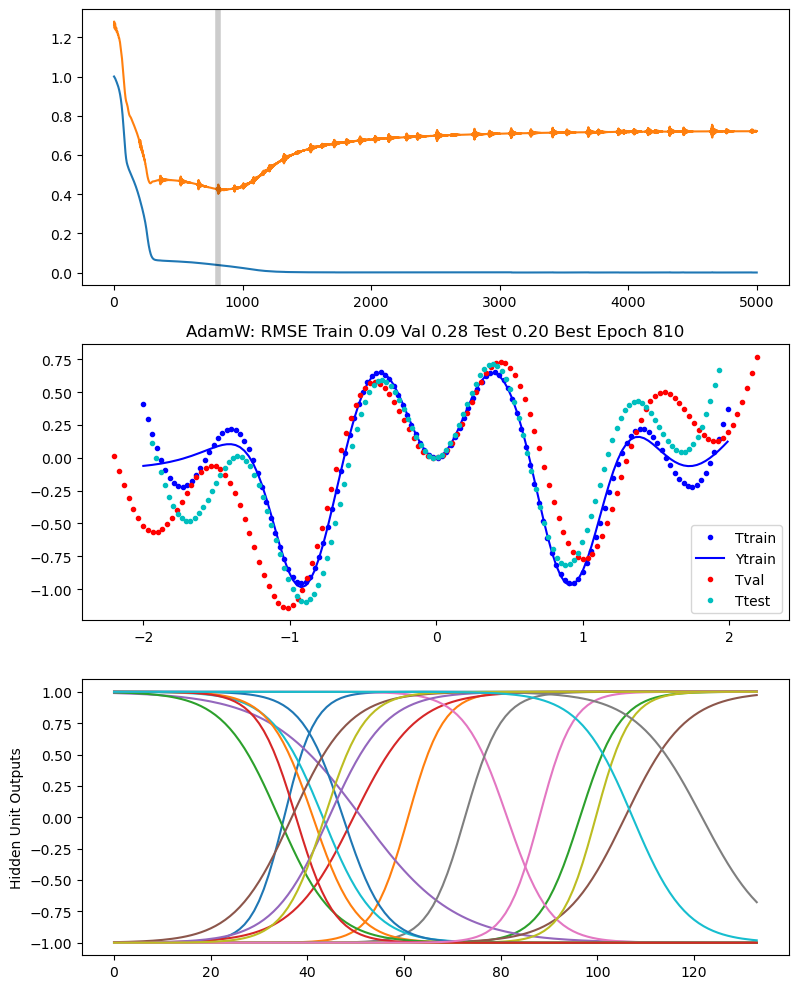

In [20]:
# n_hiddens = 10
print(f'{n_hiddens=}')

all_weights, V, W, all_gradients, grad_V, grad_W = make_weight_and_gradient_matrices(n_inputs, n_hiddens, n_outputs)
optimizer = opt.Optimizers(all_weights)
    
n_epochs = 5_000
learning_rate = 0.01
weight_penalty = 0.0
error_trace = optimizer.adamw(XtrainS, TtrainS, XvalS, TvalS, error_f, gradient_f,
                              n_epochs=n_epochs, batch_size=-1, learning_rate=learning_rate,
                              weight_penalty=weight_penalty,
                              verbose=True)
plot_results(error_trace, optimizer, 'AdamW')

n_hiddens=20
AdamW: Epoch 5000 MSE = Train 0.19415 Validate 0.53245
AdamW: Epoch 10000 MSE = Train 0.06896 Validate 0.61983
AdamW: Epoch 15000 MSE = Train 0.04848 Validate 0.69703
AdamW: Epoch 20000 MSE = Train 0.04151 Validate 0.65800
AdamW: Epoch 25000 MSE = Train 0.03798 Validate 0.64155
AdamW: Epoch 30000 MSE = Train 0.02701 Validate 0.61836
AdamW: Epoch 35000 MSE = Train 0.02644 Validate 0.61149
AdamW: Epoch 40000 MSE = Train 0.02599 Validate 0.60597
AdamW: Epoch 45000 MSE = Train 0.02557 Validate 0.60135
AdamW: Epoch 50000 MSE = Train 0.02504 Validate 0.59794


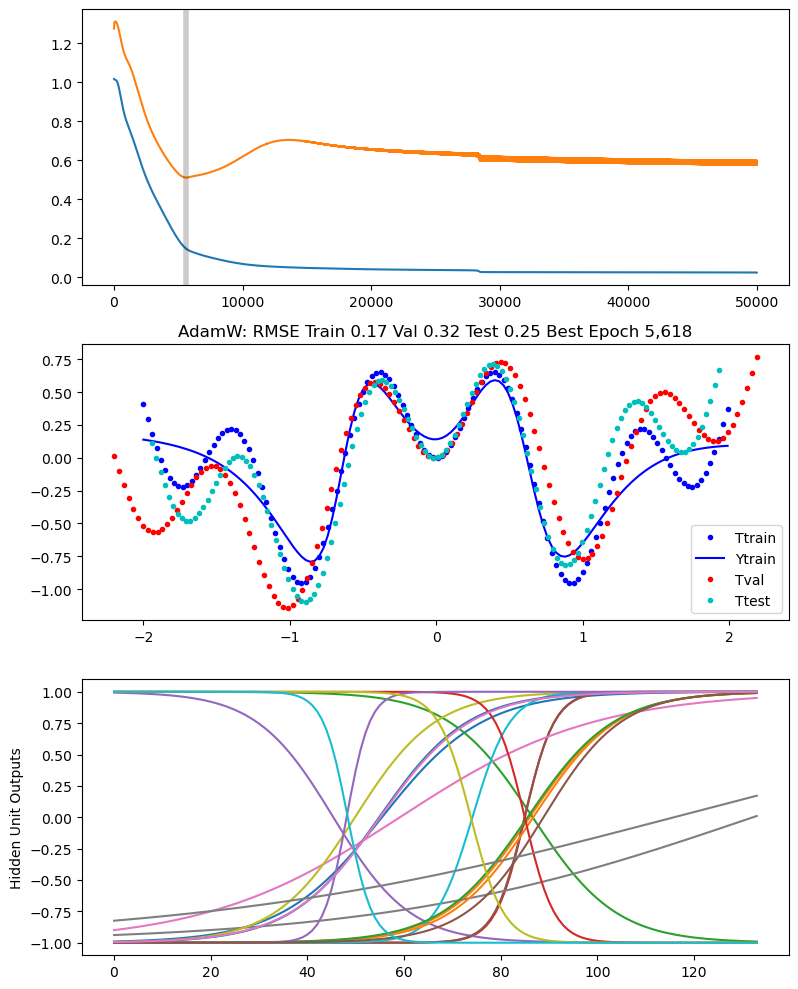

In [21]:
# n_hiddens = 10
print(f'{n_hiddens=}')

all_weights, V, W, all_gradients, grad_V, grad_W = make_weight_and_gradient_matrices(n_inputs, n_hiddens, n_outputs)
optimizer = opt.Optimizers(all_weights)
    
n_epochs = 50_000
learning_rate = 0.001
weight_penalty = 0.0
error_trace = optimizer.adamw(XtrainS, TtrainS, XvalS, TvalS, error_f, gradient_f,
                              n_epochs=n_epochs, batch_size=10, learning_rate=learning_rate,
                              weight_penalty=weight_penalty,
                              verbose=True)
plot_results(error_trace, optimizer, 'AdamW')

n_hiddens=20
SCG: Epoch 1000 MSE= Train 0.00067 Validate 0.66198
SCG: Epoch 2000 MSE= Train 0.00003 Validate 0.76717
SCG: Epoch 3000 MSE= Train 0.00001 Validate 0.79099
SCG: Epoch 4000 MSE= Train 0.00001 Validate 0.79215
SCG: Epoch 5000 MSE= Train 0.00001 Validate 0.79168
SCG: Epoch 6000 MSE= Train 0.00001 Validate 0.78976
SCG: Epoch 7000 MSE= Train 0.00001 Validate 0.78782
SCG: Epoch 8000 MSE= Train 0.00001 Validate 0.78605
SCG: Epoch 9000 MSE= Train 0.00000 Validate 0.78367
SCG: Epoch 10000 MSE= Train 0.00000 Validate 0.78204


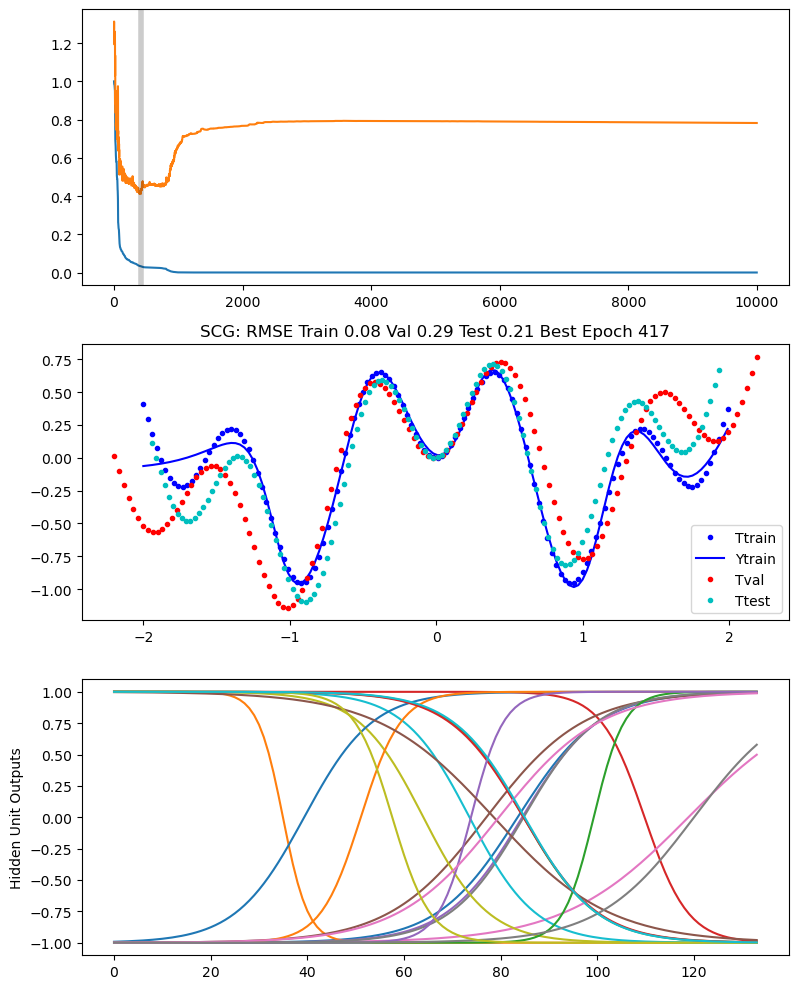

In [22]:
# n_hiddens = 10
print(f'{n_hiddens=}')

all_weights, V, W, all_gradients, grad_V, grad_W = make_weight_and_gradient_matrices(n_inputs, n_hiddens, n_outputs)
optimizer = opt.Optimizers(all_weights)
    
n_epochs = 10_000
weight_penalty = 0.0
error_trace = optimizer.scg(XtrainS, TtrainS, XvalS, TvalS, error_f, gradient_f,
                            n_epochs=n_epochs, batch_size=-1,  
                            weight_penalty=weight_penalty,
                            verbose=True) 
plot_results(error_trace, optimizer, 'SCG')

n_hiddens=20
SCG: Epoch 500 MSE= Train 0.00000 Validate 0.77342
SCG: Epoch 1000 MSE= Train 0.00000 Validate 0.76877
SCG: Epoch 1500 MSE= Train 0.00000 Validate 0.76459
SCG: Epoch 2000 MSE= Train 0.00000 Validate 0.76013
SCG: Epoch 2500 MSE= Train 0.00000 Validate 0.75602
SCG: Epoch 3000 MSE= Train 0.00000 Validate 0.75393
SCG: Epoch 3500 MSE= Train 0.00000 Validate 0.75172
SCG: Epoch 4000 MSE= Train 0.00000 Validate 0.74903
SCG: Epoch 4500 MSE= Train 0.00000 Validate 0.74777
SCG: Epoch 5000 MSE= Train 0.00000 Validate 0.74560


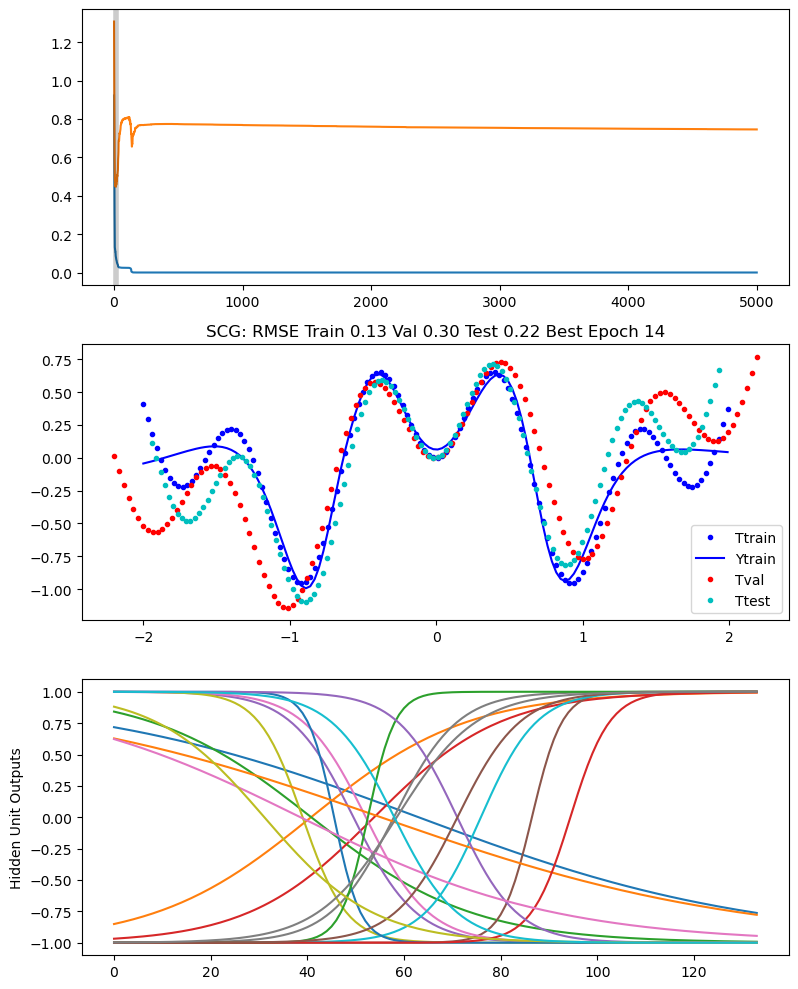

In [23]:
# n_hiddens = 10
print(f'{n_hiddens=}')

all_weights, V, W, all_gradients, grad_V, grad_W = make_weight_and_gradient_matrices(n_inputs, n_hiddens, n_outputs)
optimizer = opt.Optimizers(all_weights)
    
n_epochs = 5_000
weight_penalty = 0.0
error_trace = optimizer.scg(XtrainS, TtrainS, XvalS, TvalS, error_f, gradient_f,
                            n_epochs=n_epochs, batch_size=10, 
                            weight_penalty=weight_penalty,
                            verbose=True) 
plot_results(error_trace, optimizer, 'SCG')

n_hiddens=20
SCG: Epoch 4000 MSE= Train 0.00000 Validate 0.74571
SCG: Epoch 8000 MSE= Train 0.00000 Validate 0.75066
SCG: Epoch 12000 MSE= Train 0.00000 Validate 0.75166
SCG: Epoch 16000 MSE= Train 0.00000 Validate 0.75101
SCG: Epoch 20000 MSE= Train 0.00000 Validate 0.74929
SCG: Epoch 24000 MSE= Train 0.00000 Validate 0.74685
SCG: Epoch 28000 MSE= Train 0.00000 Validate 0.74464
SCG: Epoch 32000 MSE= Train 0.00000 Validate 0.74223
SCG: Epoch 36000 MSE= Train 0.00000 Validate 0.74060
SCG: Epoch 40000 MSE= Train 0.00000 Validate 0.73911


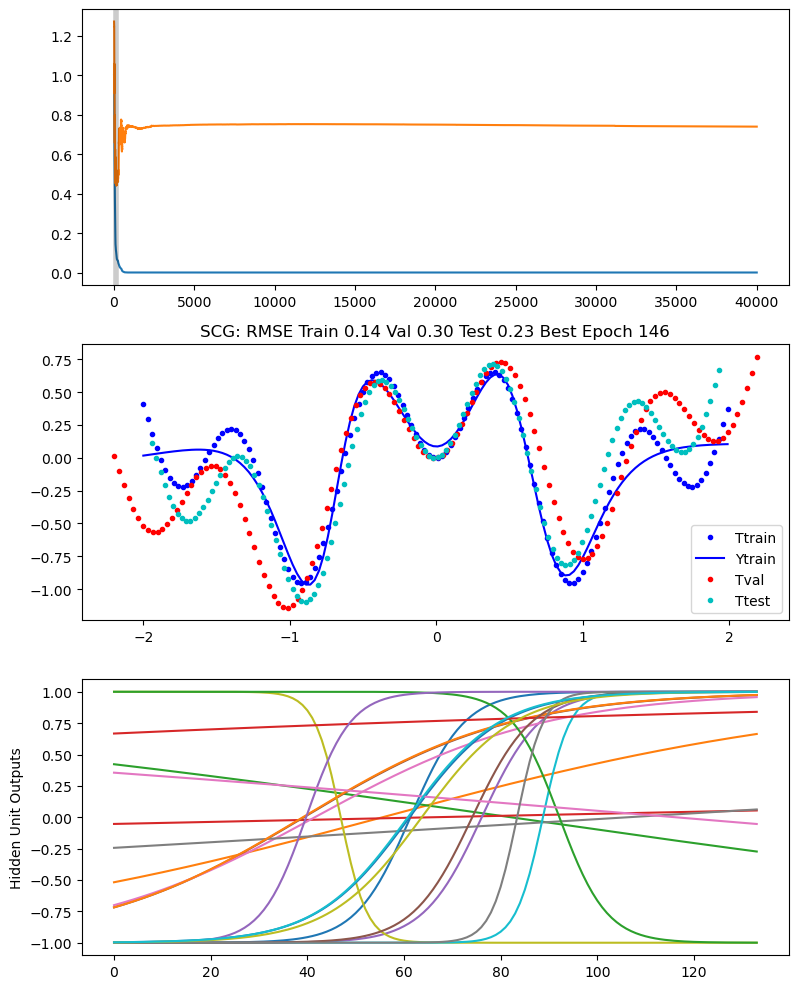

In [24]:
# n_hiddens = 10
print(f'{n_hiddens=}')

all_weights, V, W, all_gradients, grad_V, grad_W = make_weight_and_gradient_matrices(n_inputs, n_hiddens, n_outputs)
optimizer = opt.Optimizers(all_weights)
    
n_epochs = 40_000
weight_penalty = 0.0
error_trace = optimizer.scg(XtrainS, TtrainS, XvalS, TvalS, error_f, gradient_f,
                            n_epochs=n_epochs, batch_size=-1, 
                            weight_penalty=weight_penalty,
                            verbose=True) 
plot_results(error_trace, optimizer, 'SCG')

n_hiddens=20
AdamW: Epoch 100 MSE = Train 0.81206 Validate 1.21559
AdamW: Epoch 200 MSE = Train 0.63538 Validate 1.05830
AdamW: Epoch 300 MSE = Train 0.39752 Validate 0.66108
AdamW: Epoch 400 MSE = Train 0.21863 Validate 0.47719
AdamW: Epoch 500 MSE = Train 0.13005 Validate 0.42798
AdamW: Epoch 600 MSE = Train 0.08985 Validate 0.39449
AdamW: Epoch 700 MSE = Train 0.07239 Validate 0.37873
AdamW: Epoch 800 MSE = Train 0.06521 Validate 0.37063
AdamW: Epoch 900 MSE = Train 0.06094 Validate 0.36624
AdamW: Epoch 1000 MSE = Train 0.05816 Validate 0.36488


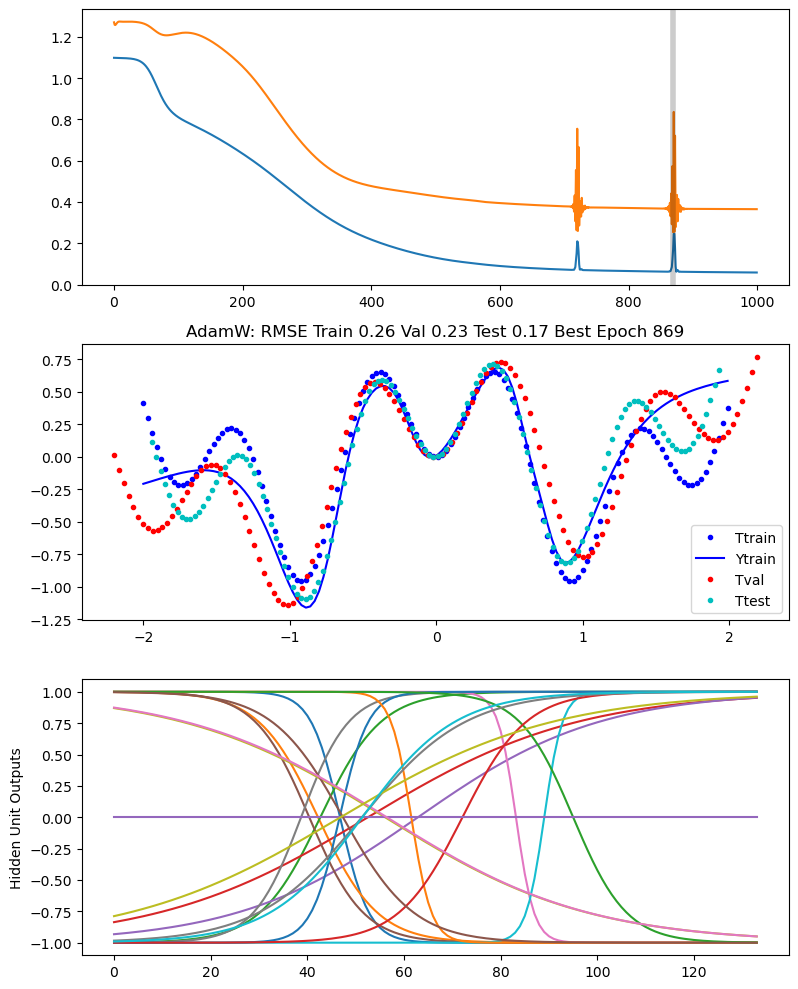

In [25]:
# n_hiddens = 10
print(f'{n_hiddens=}')

all_weights, V, W, all_gradients, grad_V, grad_W = make_weight_and_gradient_matrices(n_inputs, n_hiddens, n_outputs)
optimizer = opt.Optimizers(all_weights)
    
n_epochs = 1_000
weight_penalty = 0.0
error_trace = optimizer.adamw(XtrainS, TtrainS, XvalS, TvalS, error_f, gradient_f,
                            n_epochs=n_epochs, batch_size=20, learning_rate=0.01,
                            weight_penalty=weight_penalty,
                            verbose=True) 
plot_results(error_trace, optimizer, 'AdamW')